In [48]:
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from langchain.schema import HumanMessage, AIMessage, SystemMessage
import json

In [3]:
# Load existing multi-threaded Agent Interactions file that we will add new interactions to
# Make sure to use the correct path to your .pkl file
file_path = "./synthetic/synthetic_agent_conversations.pkl"

# Open the file and load its contents into resulting_dicts
with open(file_path, 'rb') as file:
    resulting_dicts = pickle.load(file)


In [4]:
len(resulting_dicts)

1204

In [19]:
lengths = [len(x['conversation']) for x in resulting_dicts]

In [20]:
# Counting the frequency of each length
length_counts = Counter(lengths)

In [21]:
# Preparing data for plotting
lengths_sorted = sorted(length_counts.keys())
frequencies = [length_counts[length] for length in lengths_sorted]


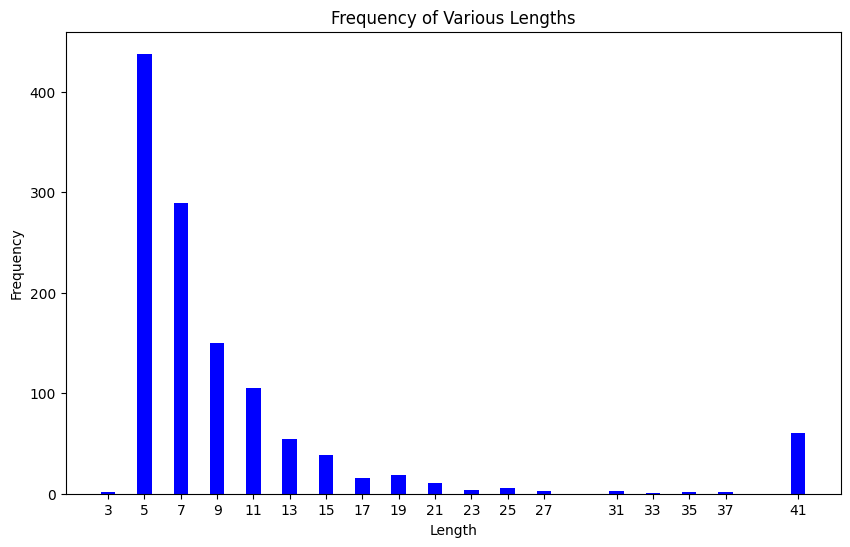

In [22]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(lengths_sorted, frequencies, color='blue')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Frequency of Various Lengths')
plt.xticks(lengths_sorted)
plt.show()

In [13]:
length_counts.keys()

dict_keys([5])

In [14]:
set(lengths)

{5}

In [25]:
long = [x for x in resulting_dicts if len(x['conversation']) > 17 and len(x['conversation']) != 41]

In [26]:
len(long)

51

In [33]:
good_chats = [x for x in resulting_dicts if len(x['conversation']) < 17 and len(x['conversation']) > 5 ]

In [34]:
len(good_chats)

637

In [35]:
seven_chats = [x for x in resulting_dicts if len(x['conversation']) == 7 ]

### Save Chats to PDF

In [27]:
import html
from IPython.display import HTML, display
import pdfkit
import html

def format_single_chat(chat_data):
    formatted_html = '<div style="border: 1px solid #ddd; padding: 10px; max-width: 1000px; margin-bottom: 20px;">'

    # Add task as a header
    formatted_html += f'<h2>Task: {html.escape(chat_data["task"])}</h2>'

    # Add environment, io, and state with a smaller font on a neutral background
    formatted_html += (
        '<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px; font-size: 0.9em;">'
        f'<strong>Environment:</strong> {html.escape(chat_data["environment"])}<br>'
        f'<strong>IO:</strong> {html.escape(chat_data["io"])}<br>'
        f'<strong>State:</strong> {html.escape(chat_data["state"])}'
        '</div>'
    )

    # Loop through the conversation
    for message in chat_data["conversation"]:
        # Depending on the message origin, use a different background color
        bg_color = "#f0f0f0" if message.__class__.__name__ == "HumanMessage" else "#d1e7fd"
        escaped_text = html.escape(message.content.strip())

        formatted_html += (
            f'<div style="background-color: {bg_color}; padding: 20px; '
            'border-radius: 5px; margin: 20px 0;">'
            f'<strong>{message.__class__.__name__.replace("Message", "")}:</strong> '
            f'{escaped_text}'
            '</div>'
        )

    formatted_html += '</div>'
    return formatted_html

def save_chats_to_pdf(list_of_chat_histories, filename):
    combined_html = ""
    for chat_history in list_of_chat_histories:
        combined_html += format_single_chat(chat_history)
    
    # Generate PDF from the combined HTML content
    pdfkit.from_string(combined_html, filename)


In [36]:
save_chats_to_pdf(seven_chats, "./synthetic/seven_chats.pdf")

### Write good data to dataset

In [41]:
fixed = []
for chat in good_chats:
    conv = chat['conversation']
    new_prompt = '####\n'.join([conv[0].content, conv[1].content])
    new_chat = [HumanMessage(content=new_prompt)] + conv[2:]
    fixed.append(new_chat)

In [53]:
conversations_ = []
for chat in fixed :
    conversation_ = []
    for side in chat:
        if side.type == "human":
            side_type = "human"
        else:
            side_type = "gpt"
        conversation_.append({"from": side_type, "value":side.content})
    conversations_.append({"conversations":conversation_})
        

In [54]:
conversations_[0]

{'conversations': [{'from': 'human',
   'value': '\nInteract with a software environment to solve a task. Imagine you are an intelligent agent working for a user and your target is to perform actions to complete the task goal. At the beginning of your interactions, you will be given a detailed description of the current environment and your goal to accomplish. For each of your turns, you will be given a list of actions which you can choose one to perform in this turn. You should provide two parts of your response: "THOUGHT" and "ACTION". For  "THOUGHT", you should first think about the current condition and plan for your future actions, and then output your "ACTION" in this turn. Your output must strictly follow this format:"THOUGHT: your thoughts.\n ACTION: your next action \n"; For "ACTION", you should directly output the action this turn. Your output must strictly follow this format:"ACTION: your next action\n". After your each turn, the environment will respond based on your action

In [55]:
with open('./synthetic/syn_env_filtered.jsonl', 'w') as file:
    for conversation in conversations_:
        json_str = json.dumps(conversation)
        file.write(json_str + "\n")